# Quantum Approximate Optimization Algorithm

In [6]:
## Necessary functions and input
%matplotlib inline
# useful additional packages 

#import math tools
import numpy as np
import random as rand
# We import the tools to handle general Graphs
import networkx as nx
from scipy.optimize import fmin, minimize,differential_evolution,brute
from qiskit.aqua.components.optimizers import COBYLA, SPSA, SLSQP
# We import plotting tools 
import matplotlib.pyplot as plt 
from   matplotlib import cm
from   matplotlib.ticker import LinearLocator, FormatStrFormatter
%config InlineBackend.figure_format = 'svg' # Makes the images look nice

# importing Qiskit
from qiskit import Aer, IBMQ
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, execute

from qiskit.providers.ibmq      import least_busy
from qiskit.tools.monitor       import job_monitor
from qiskit.visualization import plot_histogram
#IBMQ.save_account('your_account')
#provider = IBMQ.load_account()
from qiskit.visualization import plot_histogram
import qiskit.providers.aer.noise as noise
π=np.pi

### 1. Generate the graph instance using networkx

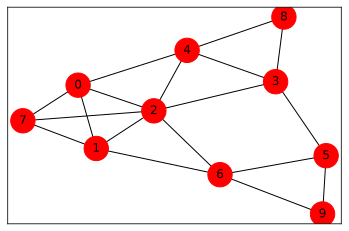

In [11]:
###

n     = 10 # Number of nodes
V     = np.arange(0,n,1) #Set of nodes
E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),
        (3,2,1.0),(3,4,1.0),(4,2,1.0),
        (2,6,1.0),(5,3,1.0),(0,4,1.0),
        (5,6,1.0),(1,6,1.0),(3,8,1.0),
        (4,8,1.0),(5,9,1.0),(2,7,1.0),
        (6,9,1.0),(1,7,1.0),(0,7,1.0)] # Set of edges with equal weights

G     = nx.Graph()
G.add_nodes_from(V)
G.add_weighted_edges_from(E)
colors       = ['r' for node in G.nodes()]
default_axes = plt.axes(frameon=True)
pos          = nx.spring_layout(G)

nx.draw_networkx(G, node_color=colors, node_size=600, alpha=1, ax=default_axes, pos=pos)

###

### 2. Implement the cost function
Here, $x$ is the input binary string and $G$ the Graph. Recall it is defined by:
$$
C(x)=\sum_{(i,j)\in E_G} x_i(1-x_j)
$$ where $E_G$ is the set of edges of $G$.

In [12]:
def cost_function_C(x,G):
    C = 0
    ###
    E = G.edges()
    if( len(x) != len(G.nodes())):
        return np.nan
        
    C = 0;
    for index in E:
        e1 = index[0]
        e2 = index[1]
        
        w      = G[e1][e2]['weight']
        C = C + w*x[e1]*(1-x[e2]) + w*x[e2]*(1-x[e1])
    ###
    return C

### 3. Implement the QAOA circuit corresponding to the cost function

In [13]:
def QAOA_circuit(γ,β,G):  
    """
    Returns an appropriate quantum circuit mapping p blocks (length of γ,β) 
    of evolution according to the cost Hamiltonian induced by graph G"""
    assert len(γ) = len(β)
    n = len(G.nodes())
    p = len(γ)
    QAOA=QuantumCircuit(n, n)
    QAOA.h(range(n))
    QAOA.barrier()
    
    for i in range(p): #exp(-i*γ*H_c) repeated with different angles γ for each block
        for edge in G.edges():
            k = edge[0]
            l = edge[1]
            QAOA.cu1(2*γ[i], k, l)
            QAOA.u1(-γ[i], k)
            QAOA.u1(-γ[i], l)
    
    # then apply the single qubit X - rotations with angle β to all qubits (exp(-i*β*H_b))
        QAOA.barrier()
        QAOA.rx(-2*β[i], range(n))

    # Finally measure the result in the computational basis
    QAOA.barrier()
    QAOA.measure(range(n),range(n))
    ###
    return QAOA

In [16]:
def best_string(angles,G,prob=[0.,0.,0.],backend_1=Aer.get_backend("qasm_simulator"),shots_1=10000,noise=False):
    
    
    l=len(angles)
    γ=angles[0:l:2]
    β=angles[1:l:2]
    if(noise):
        simulate=execute(QAOA_noisy_local_model(γ,β,G,prob),backend=backend_1,shots=shots_1)
    else:
        simulate=execute(QAOA_circuit(γ,β,G),backend=backend_1,shots=shots_1)
    QAOA_results=simulate.result()
    counts=QAOA_results.get_counts()
    
    avr_C       = 0
    max_C       = [0,0]

    for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
        #print(sample,tmp_eng)
    
    # compute the expectation value and energy distribution
        avr_C     = avr_C    + counts[sample]*tmp_eng
        #print("bitstring :",sample,"prob: ",counts[sample]/shots_1, "associated cost:", tmp_eng)
        # save best bit string
        if( max_C[1] < tmp_eng):
            max_C[0] = sample
            max_C[1] = tmp_eng
    max_C.append(counts[max_C[0]]/shots_1)
    
    
                
    Mp_sampled   = avr_C/shots_1
    
    return Mp_sampled, max_C, counts

def computation(angles,G=None,backend_1=Aer.get_backend("qasm_simulator"),shots_1=10000,prob=[0.,0.,0.]): #New function similar to computation, but for the new graph
    if (G==None): # Define the Graph here if not possible to define it outside the function, this is the case for integrated Qiskit optimizers, such as SPSA which is the most suited here
        n     = 7
        V     = np.arange(0,n,1)
        E     =[(0,1,1.0),(0,2,1.0),(1,2,1.0),(3,2,1.0),(3,4,1.0),(4,2,1.0),(2,6,1.0),(5,3,1.0),(0,4,1.0),(5,6,1.0),(1,6,1.0)] 
        G     = nx.Graph()
        G.add_nodes_from(V)
        G.add_weighted_edges_from(E)
        
    l=len(angles)
    γ=angles[0:l:2]
    β=angles[1:l:2]
    simulate=execute(QAOA_circuit(γ,β,G),backend=backend_1,shots=shots_1)
    QAOA_results=simulate.result()
    counts=QAOA_results.get_counts()
    
    avr_C       = 0

    for sample in list(counts.keys()):

    # use sampled bit string x to compute C(x)
        x         = [int(num) for num in list(sample)]
        tmp_eng   = cost_function_C(x,G)
    
    # compute the expectation value and energy distribution
        avr_C     = avr_C    + counts[sample]*tmp_eng
        
    
    
                
    Mp_sampled   = avr_C/shots_1
    
    return -Mp_sampled

def result_optimization(G,optimizer='COBYLA',p_min=1,p_max=5,prob=[0.,0.,0.],backend=Aer.get_backend("qasm_simulator")):
    p=[]
    exp=[]
    opti_angles=[]
    ratio=[]
    max_value=9.
    
    for j in range(p_min,p_max+1):
        if (j==1):
            print("Optimization for",j,"block")
        else:
            print("Optimization for",j,"blocks")
        angles=[]
        min_bound=[]
        max_bound=[]
        for i in range(j):
            a=rand.uniform(0,2*π)
            b=rand.uniform(0,π)
            angles.append(a)
            angles.append(b)
            min_bound.append(0.)
            min_bound.append(0.)
            max_bound.append(2*π)
            max_bound.append(π)
        
        
        p.append(j)
        boundaries=[]

        for i in range(2*j):
            boundaries.append((min_bound[i],max_bound[i]))
        
        if (optimizer=='brute'):
            opti_angles1,expminus=brute(func=computation,ranges=boundaries,args=(G,backend,10000,prob),Ns=10,finish=fmin)
            exp.append(-expminus)
            ratio.append(-expminus/9.0)
            opti_angles.append(opti_angles1)
        elif (optimizer=='differential_evolution'):
            Opti_Result=differential_evolution(computation,bounds=boundaries,args=(G,backend,10000,prob),tol=0.1)
            opti_angles.append(Opti_Result.x)
            exp.append(-Opti_Result.fun)
            ratio.append(-Opti_Result.fun/9.0)
        elif (optimizer=='SPSA'):
            op=SPSA(max_trials=1000*j)
            #op.wrap_function(computation,(G,backend,10000,prob))
            opti_angles1,expminus,nfv=op.optimize(len(angles),computation,variable_bounds=boundaries,initial_point=angles)
            exp.append(-expminus)
            ratio.append(-expminus/9.0)
            opti_angles.append(opti_angles1)
        else:
            Opti_Result=minimize(fun=computation,x0=angles,args=(G,backend,10000,prob),method= optimizer,
                        bounds=boundaries)
            opti_angles.append(Opti_Result.x)
            exp.append(-Opti_Result.fun)
            ratio.append(-Opti_Result.fun/9.0)
            
    print("Optimization done")
    return p,ratio,exp,opti_angles

In [17]:
p,ratio,exp,opti_angles_simulator_cobyla=result_optimization(G,optimizer='differential_evolution',p_max=8)

Optimization for 1 block


<ipython-input-13-15e4dad04368>:13: DeprecationWarning: The QuantumCircuit.cu1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.cp method instead, which acts identically.
  QAOA.cu1(2*γ[i], k, l)
<ipython-input-13-15e4dad04368>:14: DeprecationWarning: The QuantumCircuit.u1 method is deprecated as of 0.16.0. It will be removed no earlier than 3 months after the release date. You should use the QuantumCircuit.p method instead, which acts identically.
  QAOA.u1(-γ[i], k)


Optimization for 2 blocks
Optimization for 3 blocks
Optimization for 4 blocks
Optimization for 5 blocks
Optimization for 6 blocks
Optimization for 7 blocks
Optimization for 8 blocks
Optimization done


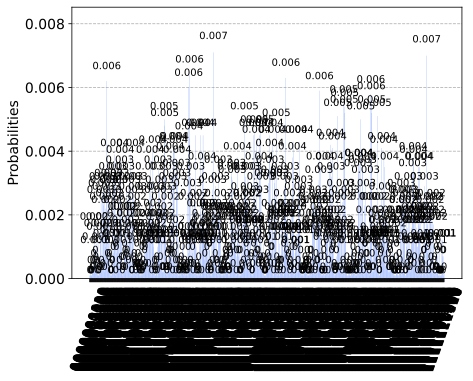

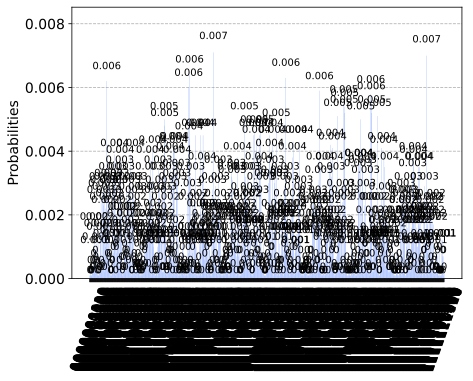

In [23]:
Mp, max_C, counts=best_string(opti_angles_simulator_cobyla[1],G)
plot_histogram(counts)